Alignement aux données du dataset Kaggle
- Csv avait une colonne en plus "Time of maximum wind gust" qui a été retiré
- Colonnes avec WindSpeed/ Wind Gust : "Calm" est remplacé par 0


A noter : 
Certains relevés sont des aggrégats de station (sydney). Est-ce que l'on prévoit mieux lorsque une station est une combinaison de relevés ou lorsque nous avons complété ces manquants (car la station n'avait pas l'équipement : ex DartMoor) avec nos imputer?

-> voir visuel missingno par station plus bas

Station en plus : PB_Goulburn

# 1 Import des librairies

In [18]:
import pandas as pd
import numpy as np
import requests
from io import StringIO

import pickle
import os

from datetime import datetime
from dateutil.relativedelta import relativedelta

## Préparation à l'import

#### Dictionnaires et listes nécessaires pour l'URL du csv

In [19]:
#liste des mois

# Mois courant
mois_courant = datetime.now().replace(day=1)

# Mois de départ = mois précédent
mois_depart = mois_courant - relativedelta(months=1)

# Générer les 13 mois vers le passé (de -12 à 0 mois avant mois_depart)
liste_mois = [(mois_depart - relativedelta(months=i)).strftime("%Y%m") for i in reversed(range(13))]

print(liste_mois)

['202405', '202406', '202407', '202408', '202409', '202410', '202411', '202412', '202501', '202502', '202503', '202504', '202505']


In [20]:
#liste des stations 
# ## #Aller chercher à la main toutes les stations  

# Note 1 : Some cloud observations are from automated equipment; these are somewhat different to those made by a human observer and may not appear every day.
#1 nom dans df ref, plusieurs stations à ce nom sur BOM : http://www.bom.gov.au/climate/data/ Regarder les Rainfall pour chacune des stations et comparer avec le dfreference pour ce jour et cette station (Richmond, Cobar, Albany...)

#FORMAT : “nom_du_rapport_généré_par_le_BOM”: (Nom de la station sur BOM(_combined), 
                                      # code de la station, 
                                      # Nom de la station dans le champ “Location” du jeu de données Kaggle, 
                                      # Note 1),

dico_stations_DWO = {
    "IDCJDW5001": ("Adelaide Airport", "023034", "Adelaide", "Note 1"),
    "IDCJDW6002": ("Albany", "009999", "Albany", "Note 1"),#Dans df Reference, rainfall proviennent de 009500
    "IDCJDW2002": ("Albury-Wodonga", "072160", "Albury", ""),
    "IDCJDW8002": ("Alice Springs", "015590", "AliceSprings", ""),
    "IDCJDW2005": ("Badgerys Creek", "067108", "BadgerysCreek", ""),
    "IDCJDW3005": ("Ballarat", "089002", "Ballarat", "Note 1"),
    "IDCJDW3008": ("Bendigo", "081123", "Bendigo", "Note 1"),
    "IDCJDW4020": ("Brisbane", "040842", "Brisbane", ""),
    "IDCJDW4154": ("Cairns Racecourse", "031222", "Cairns", ""),#Histo rainfall different
    "IDCJDW2801": ("Canberra Airport", "070351", "Canberra", ""), 
    "IDCJDW2029": ("Cobar", "048027", "Cobar", "Note 1"), 
    "IDCJDW2030": ("Coffs Harbour", "059151", "CoffsHarbour", "Note 1"),  #Prior to February 2015, observations were recorded against Coffs Harbour MO (site number 059040).
    "IDCJDW3101": ("Dartmoor_combined", "090194", "Dartmoor", ""),#Temperature, humidity, wind, pressure and rainfall observations are from Dartmoor {station 090194}. 
    #Evaporation and sunshine observations are from Mount Gambier Aero {station 026021}.
    # #Mt Gambier is about 50 km to the west of Dartmoor, and conditions may differ markedly between the two on any given day; the results for evaporation and sunshine, and the climate averages listed below, should be used with caution.
    "IDCJDW8014": ("Darwin", "014015", "Darwin", ""),
    "IDCJDW4050": ("Gold Coast", "040764", "GoldCoast", ""),#Automatic Weather Station (AWS) at the northern end of Southport Spit
    "IDCJDW7062": ("Hobart Airport", "094250", "Hobart", ""), #Histo sur station combinée Hobart : Battery Point + Hobart Airport
    "IDCJDW8048": ("Tindal RAAF,", "014932", "Katherine", "Note 1"),#Tindal RAAF base is 14 km ESE of Katherine. Meteorological observations at Tindal RAAF are used to represent conditions in Katherine. #histo different!
    "IDCJDW7026": ("Launceston Airport", "091311", "Launceston", "Note 1"),
    "IDCJDW3050": ("Melbourne_combined", "086338", "Melbourne", ""), #Rainfall : Olympic Park 86338, Evaporation : Airport 86282 (comme dans le df de reference) #On Tuesday 6 January 2015, the Melbourne (Latrobe Street) observation station permanently closed.
    "IDCJDW3049": ("Melbourne Airport", "086282", "MelbourneAirport", ""),
    "IDCJDW3051": ("Mildura Airport", "076031", "Mildura", ""),
    "IDCJDW2084": ("Moree", "053115", "Moree", ""),
    "IDCJDW5041": ("Mount Gambier Aero", "026021", "MountGambier", "Note 1"),
    "IDCJDW2804": ("Mount Ginini AWS", "070349", "MountGinini", ""),
    "IDCJDW2097": ("Newcastle_combined", "061055", "Newcastle", ""),  #Most observations from Nobbys Head, but cloud from Williamtown RAAF (Station No. 061078).
    "IDCJDW3059": ("Nhill Aerodrome", "078015", "Nhil", ""),
    "IDCJDW2099": ("Norah Head", "061366", "NorahHead", ""),
    "IDCJDW2100": ("Norfolk Island", "200288", "NorfolkIsland", ""),
    "IDCJDW5049": ("Nuriootpa Pirsa", "023373", "Nuriootpa", ""),
    "IDCJDW6108": ("Pearce RAAF_combined", "009021", "PearceRAAF", "Note 1"),#Temperature, humidity, wind, pressure, cloud and rainfall observations are from Pearce RAAF {station 009053}. 
    #Sunshine observations are from Perth Airport {station 009021}. The mean sea level pressure at Perth Airport is provided for convenience. On most occasions it will be within 1 hPa of that at Pearce.
    "IDCJDW2111": ("Penrith", "067113", "Penrith", ""),
    "IDCJDW6111": ("Perth_combined", "009225", "Perth", ""),#Temperature, humidity, wind, pressure and rainfall observations are from Perth Metro {station 009225}. 
    #Cloud, evaporation and sunshine observations are from Perth Airport {station 009021}.
    #Significant variations can be experienced across the Perth metropolitan area on individual days. On average the inner city area is warmer overnight than the current observation sites. The current official Perth observation site is Perth Metro, however in the past Perth Regional Office and Perth Gardens have been official Perth observation sites.Some cloud observations are from automated equipment; these are somewhat different to those made by a human observer and may not appear every day.
    "IDCJDW6110": ("Perth Airport", "009021", "PerthAirport", "Note 1"),
    "IDCJDW3068": ("Portland", "090171", "Portland", "Note 1"), #Temperature, humidity, wind, pressure, cloud and rainfall observations are from Portland Airport {station 090171}. Evaporation and sunshine observations are from Mount Gambier Aero {station 026021}.
    "IDCJDW2119": ("Richmond", "067105", "Richmond", ""),  #Most observations from the RAAF base, but evaporation from the Hawkesbury campus of the University of Western Sydney Richmond - UWS Hawkesbury {station 067021}.
    "IDCJDW3021": ("East Sale Airport", "085314", "Sale", ""),
    "IDCJDW6119": ("Salmon Gums Res.Stn", "012071", "SalmonGums", ""),    
    "IDCJDW2125": ("Sydney Airport", "066037", "SydneyAirport", ""),
    "IDCJDW2124": ("Sydney (Observatory Hill)_combined", "066214", "Sydney", ""),  #Temperature, humidity and rainfall observations are from Sydney (Observatory Hill) {station 066214}. 
    #Pressure, cloud, evaporation and sunshine observations are from Sydney Airport AMO {station 066037}. Sydney Airport is about 10 km to the south of Observatory Hill.  #Wind observations are from Fort Denison {station 066022}.
    "IDCJDW4128": ("Townsville Aero", "032040", "Townsville", ""),
    "IDCJDW2802": ("Tuggeranong (Isabella Plains)", "070329", "Tuggeranong", ""),
    "IDCJDW8056": ("Yulara Airpor", "015635", "Uluru", "Note 1"), #Yulara Airport is about 20 kilometres away from Uluru.
    "IDCJDW2139": ("Wagga Wagga", "072150", "WaggaWagga", ""),
    "IDCJDW6138": ("North Walpole", "009998", "Walpole", ""),#The North Walpole observation site is approximately 3 kilometres north-northwest of Walpole and at higher elevation, so significantly different conditions may be experienced at the two places on particular days.
    "IDCJDW3079": ("Watsonia_combined", "086068", "Watsonia", "Note 1"), #Temperature, humidity, wind, pressure and rainfall observations are from Viewbank {station 086068}. Cloud, evaporation and sunshine observations are from Melbourne Airport {station 086282}.
#This same data is also available under the location name "Viewbank". 
    "IDCJDW2145": ("Williamtown", "061078", "Williamtown", "Note1"),
    "IDCJDW6081": ("Witchcliffe (Margaret River District)", "109521", "Witchcliffe", ""),#Observations are from Witchliffe West (109521) which opened in June 2022. Histo sur Margaret River 9574 fermé en Aout 2024
    "IDCJDW2146": ("Wollongong: Bellambi AWS combined Albion Park ", "068228", "Wollongong", "Note 1 "), #Temperature, humidity, wind, cloud and rainfall observations are from Bellambi AWS {station 068228}. Pressure observations are from Albion Park (Shellharbour Airport) {station 068241}. 
    #Albion Park is about 25 km southwest of Bellambi (and 18 km from Wollongong), and the pressure there will sometimes be markedly different.
    "IDCJDW5072": ("Woomera Aerodrome", "016001", "Woomera", "Note 1"),
    "IDCJDW2049": ("Goulburn: Goulburn Airport AWS combined Goulburn Tafe", "070330", "PB_Goulburn", ""), #Temperature, humidity, wind, pressure and rainfall observations are from Goulburn Airport AWS {station 070330}. Cloud and evaporation observations are from Goulburn Tafe {station 070263}.
}

#### Ajout au dictionnaire de stations du territoire (=Territory) et le District Rainfall : cela pourra être intéressant sur de l'EDA ou pour la restitutaion sur Streamlit

Le dictionnaire contient code du rapport météo, nom de la station, code de la station. A partir du code de la station on peut en déduire le territoire (=Territory) et le District Rainfall. http://www.bom.gov.au/climate/how/raindist.pdf


In [21]:
def add_rainfall_district_and_territory(dico_stations):
    # Function to get rainfall district and territory based on district code
    def get_rainfall_and_territory(district_code):
        # Check the first character of the district code to determine the territory
        # If the district_code is valid (not 'XXXXXX' or empty)
        if district_code != "XXXXXX" and district_code != "":
            if district_code[0] in ('0', '1'): #http://www.bom.gov.au/climate/cdo/about/site-num.shtml
                # rainfall district ranges based on territory
                district = int(district_code[1:3])
                if district == 70:
                    territory = "Australian Capital Territory"
                elif 1 <= district <= 13:
                    territory = "Western Australia"
                elif 14 <= district <= 15:
                    territory = "Northern Territory"
                elif 16 <= district <= 26:
                    territory = "South Australia"
                elif 27 <= district <= 45:
                    territory = "Queensland"
                elif 46 <= district <= 75:
                    territory = "New South Wales"
                elif 76 <= district <= 90:
                    territory = "Victoria"
                elif 91 <= district <= 99:
                    territory = "Tasmania"
                else:
                    territory = "Unknown"  # Case where the district code is out of known ranges
            else:
                # For non-Bureau sites or islands/Antarctica
                if district_code.startswith('200'):
                    territory = "Islands"
                elif district_code.startswith('300'):
                    territory = "Antarctica"
                elif 501 <= int(district_code[:3]) <= 599:
                    territory = "Non-Bureau sites"
                else:
                    territory = "Unknown"
                district = "999"  # No specific rainfall district for these cases
        else:
            # If the district code is invalid or missing, assign default values
            district = "N/A"
            territory = "Unknown"

        return district, territory
    
    # Iterate over the dictionary and add rainfall district and territory
    for key, value in dico_stations.items():
        district_code = value[1]  # Get the district code from the second position of the tuple
        district, territory = get_rainfall_and_territory(district_code)
        dico_stations[key] = value + (district, territory)  # Add district and territory to the tuple

    return dico_stations



In [22]:
dico_stations_updated = add_rainfall_district_and_territory(dico_stations_DWO)

for key, value in dico_stations_updated.items():
    print(f'"{key}": {value},', end='\n')  

"IDCJDW5001": ('Adelaide Airport', '023034', 'Adelaide', 'Note 1', 23, 'South Australia'),
"IDCJDW6002": ('Albany', '009999', 'Albany', 'Note 1', 9, 'Western Australia'),
"IDCJDW2002": ('Albury-Wodonga', '072160', 'Albury', '', 72, 'New South Wales'),
"IDCJDW8002": ('Alice Springs', '015590', 'AliceSprings', '', 15, 'Northern Territory'),
"IDCJDW2005": ('Badgerys Creek', '067108', 'BadgerysCreek', '', 67, 'New South Wales'),
"IDCJDW3005": ('Ballarat', '089002', 'Ballarat', 'Note 1', 89, 'Victoria'),
"IDCJDW3008": ('Bendigo', '081123', 'Bendigo', 'Note 1', 81, 'Victoria'),
"IDCJDW4020": ('Brisbane', '040842', 'Brisbane', '', 40, 'Queensland'),
"IDCJDW4154": ('Cairns Racecourse', '031222', 'Cairns', '', 31, 'Queensland'),
"IDCJDW2801": ('Canberra Airport', '070351', 'Canberra', '', 70, 'Australian Capital Territory'),
"IDCJDW2029": ('Cobar', '048027', 'Cobar', 'Note 1', 48, 'New South Wales'),
"IDCJDW2030": ('Coffs Harbour', '059151', 'CoffsHarbour', 'Note 1', 59, 'New South Wales'),
"ID

### Exporter le dico des stations

In [23]:
#Création du dossier si nécessaire
os.makedirs("dico_scaler", exist_ok=True)

# Sauvegarde dans le dossier "csv source"
with open("dico_scaler/dico_station.pkl", "wb") as fichier:
    pickle.dump(dico_stations_updated, fichier)

#### Noms des colonnes attendus dans le df

In [24]:
#Dictionnaire pour renommer les colonnes issues du csv
nom_colonnes_df_principal = {"Minimum temperature (°C)" : "MinTemp", 
                             "Maximum temperature (°C)": "MaxTemp",
                             "Rainfall (mm)" : "Rainfall", 
                             "Evaporation (mm)" : "Evaporation", 
                             "Sunshine (hours)" :"Sunshine",
                             "Direction of maximum wind gust ":"WindGustDir", 
                             "Speed of maximum wind gust (km/h)" : "WindGustSpeed",
                             "Time of maximum wind gust" : "Time of maximum wind gust" ,  #nouvelle colonne
                             "9am Temperature (°C)": "Temp9am",
                             "9am relative humidity (%)" : "Humidity9am", 
                             "9am cloud amount (oktas)":"Cloud9am",
                             "9am wind direction" :"WindDir9am", 
                             "9am wind speed (km/h)": "WindSpeed9am", 
                             "9am MSL pressure (hPa)":"Pressure9am",
                             "3pm Temperature (°C)":"Temp3pm", 
                             "3pm relative humidity (%)":"Humidity3pm",
                             "3pm cloud amount (oktas)": "Cloud3pm", 
                             "3pm wind direction" : "WindDir3pm",
                             "3pm wind speed (km/h)": "WindSpeed3pm", 
                             "3pm MSL pressure (hPa)":"Pressure3pm"}



## Récupération des datas et création d'un df consolidé :  df_conso_station

In [25]:
#liste des url des csv à récupérer
compteur = 0 #pour consolider les df de station dans un un seul df : df_conso_station
df_conso_station=pd.DataFrame()

for no_report in dico_stations_DWO :
    i=0
    compteur+= 1
    df_une_station=pd.DataFrame()

    for le_annee_mois in liste_mois :
        url_concatene = ("http://www.bom.gov.au/climate/dwo/"+str(le_annee_mois)+"/text/"+no_report+"."+le_annee_mois+".csv") # Exemple : http://www.bom.gov.au/climate/dwo/202412/text/IDCJDW2804.202412.csv
        i+= 1
        # Essayer de télécharger le fichier avec des en-têtes de type navigateur
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36'
        }

        # Effectuer la requête
        response = requests.get(url_concatene, headers=headers)

        # Vérifier si la requête est réussie
        if response.status_code == 200:
            # Utiliser StringIO pour lire le texte CSV dans un DataFrame
            csv_data = StringIO(response.text)
            
            # L'entete n'est a=pas toujours sur la meme ligne : On lit le fichier ligne par ligne pour trouver le header qui commence par ,"Date", 
            lines = response.text.splitlines()
            # Trouver la ligne où "Date" apparaît pour la première fois
            header_row = None
            for i, line in enumerate(lines):
                if "Date" in line:
                    header_row = i
                    break
            
            df_recupere = pd.read_csv(csv_data, sep=",", skiprows=header_row, encoding="latin1")

            
            #Faire un df consolidé par station
            if i == 1 :
                df_une_station = df_une_station
            else :
                df_une_station = pd.concat([df_une_station, df_recupere], ignore_index=True) 
        
        else:
            print(f"Erreur lors du chargement de l'URL pour ",le_annee_mois," de ",dico_stations_DWO[no_report][2],": {response.status_code}")
    
    #Mettre les noms de colonnes du df principal
    df_une_station = df_une_station.rename(nom_colonnes_df_principal, axis = 1) 

    #Suppression de colonnes
    df_une_station = df_une_station.drop(["Unnamed: 0","Time of maximum wind gust"],axis =1)

    #Ajout de colonnes
    #Insérer en 2e position (loc=1) le nom de la station (3e colonne du dico) associé à ce rapport dans le dictionnaire dico_stations_DWO
    df_une_station.insert(1,column="Location", value=dico_stations_DWO[no_report][2]) 

    df_une_station["RainToday"]=df_une_station["Rainfall"].apply(lambda x: "Yes" if x>1 else "No")
    #Met les valeurs de RainToday à l'indice précédent dans RainTomorrow 
    df_une_station["RainTomorrow"] = np.roll(df_une_station["RainToday"].values, 1) #Ex RainToday 02/01/24 -> RainTomorrow 01/01/2024
    
    #Supprimer le dernier relevé du df car RainTomorrow y sera toujours inconnu (suite au np.roll c'est la valeur de RainToday a la 1e ligne du df, et il aurait fallu celle du lendemain de la dernier ligne du df).
    df_une_station.drop(df_une_station.index[-1], inplace=True)

    #Mettre les colonnes dans le même ordre que le df de départ du projet
    df_reference=pd.read_csv("data/weatherAUS.csv",parse_dates=["Date"])
    df_une_station = df_une_station[df_reference.columns]


    #Faire un df consolidé (df_conso_station) des df unitaire par station (df_une_station)
    if compteur == 1 :
        df_conso_station = df_une_station
    else :
        df_conso_station = pd.concat([df_conso_station, df_une_station], ignore_index=True) 

display(df_conso_station.head(2))

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2024-05-1,Adelaide,7.9,19.2,0.0,4.2,6.6,SE,35.0,ESE,...,74.0,42.0,1033.5,1029.2,7.0,NaN,12.4,18.5,No,No
1,2024-05-2,Adelaide,11.7,21.4,0.0,2.6,9.9,SE,35.0,SE,...,57.0,40.0,1030.7,1027.6,1.0,NaN,15.7,20.8,No,No


In [26]:
display(df_conso_station.tail(2))
df_conso_station.info()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
19748,2025-05-29,PB_Goulburn,-2.5,14.3,0.2,1.4,NaN,SSE,19.0,N,...,99.0,56.0,1022.0,1021.2,1.0,NaN,4.0,13.9,No,No
19749,2025-05-30,PB_Goulburn,-3.7,17.2,0.0,0.8,NaN,ESE,20.0,SSW,...,99.0,31.0,1026.3,1025.3,1.0,NaN,1.9,16.5,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19750 entries, 0 to 19749
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           19750 non-null  object 
 1   Location       19750 non-null  object 
 2   MinTemp        19627 non-null  float64
 3   MaxTemp        19624 non-null  float64
 4   Rainfall       19388 non-null  float64
 5   Evaporation    5266 non-null   float64
 6   Sunshine       4288 non-null   float64
 7   WindGustDir    19201 non-null  object 
 8   WindGustSpeed  19288 non-null  float64
 9   WindDir9am     19585 non-null  object 
 10  WindDir3pm     19588 non-null  object 
 11  WindSpeed9am   19585 non-null  object 
 12  WindSpeed3pm   19588 non-null  object 
 13  Humidity9am    19588 non-null  float64
 14  Humidity3pm    19603 non-null  float64
 15  Pressure9am    18524 non-null  float64
 16  Pressure3pm    18526 non-null  float64
 17  Cloud9am       9024 non-null   float64
 18  Cloud3

In [27]:
#Verifier mapping exaustif avec df_reference
# Récupérer les valeurs uniques de "Location" dans chaque DataFrame
locations_reference = df_reference["Location"].unique()
locations_conso_station = df_conso_station["Location"].unique()

# Trouver les éléments présents dans df_reference mais pas dans df_conso_station
locations_reference_non_mappees = [loc for loc in locations_reference if loc not in locations_conso_station]

# Trouver les éléments présents dans df_conso_station mais pas dans df_reference
locations_conso_station_non_mappees = [loc for loc in locations_conso_station if loc not in locations_reference]

# Afficher les résultats
print("Locations de df_reference non mappées :")
print(locations_reference_non_mappees)

print("Locations de df_conso_station non mappées :")
print(locations_conso_station_non_mappees)


Locations de df_reference non mappées :
[]
Locations de df_conso_station non mappées :
['PB_Goulburn']


In [28]:
# Modification de la vitesse "Calm" par 0km/h
df_conso_station["WindSpeed9am"] = df_conso_station["WindSpeed9am"].apply(lambda x: 0 if x =="Calm" else x)
df_conso_station["WindSpeed3pm"] = df_conso_station["WindSpeed3pm"].apply(lambda x: 0 if x =="Calm" else x)
df_conso_station["WindGustSpeed"] = df_conso_station["WindGustSpeed"].apply(lambda x: 0 if x =="Calm" else x)

### CREATION DU CSV

In [29]:
#Création du csv 24-25
df_conso_station.to_csv("data/data_2024-25.csv", index = False)

# 0 - Inutile : A servi à visualiser les données, et faire quelques analyses

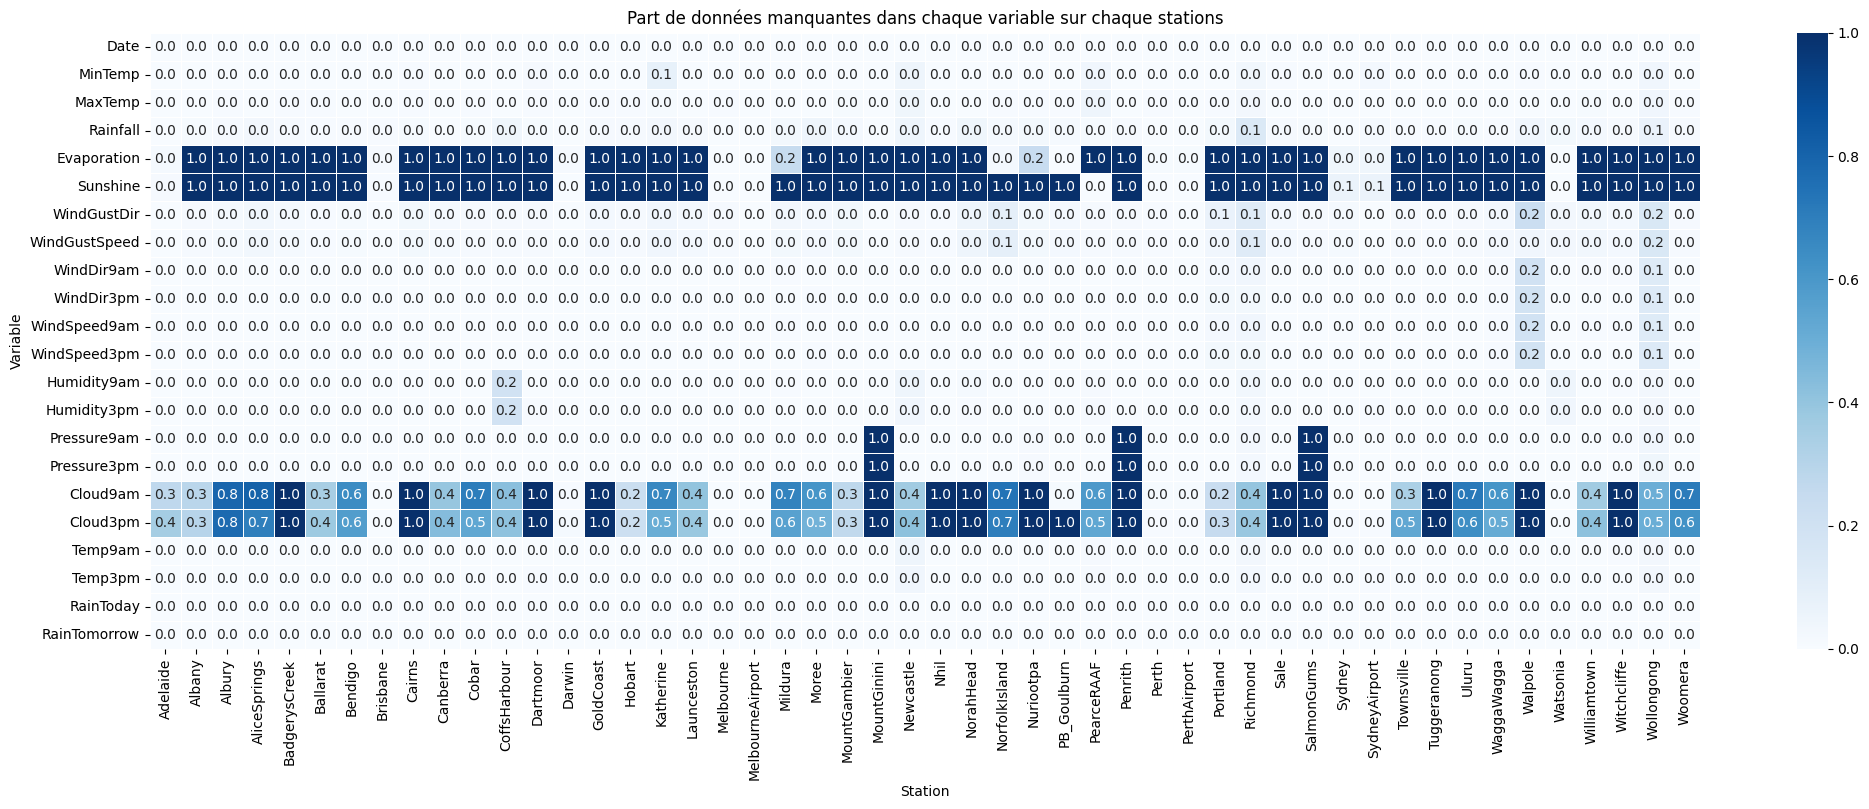

In [30]:
#GRAPH %de NAN par variables et par station sur data_2024
import missingno as msno 
import matplotlib.pyplot as plt
import seaborn as sns

#Dataframe avec Booleen pour NAN sur toutes les colonnes sauf location
df_sans_location= df_conso_station.drop("Location",axis = 1).iloc[:, :].isna() 
df_col_location =  df_conso_station.iloc[:, 1:2]
df_NAN_apres_3e_col= df_col_location .join(df_sans_location)

df_NAN_Location = df_NAN_apres_3e_col.groupby("Location").mean()

# Affichage graphe

plt.figure(figsize=(25, 8))
sns.heatmap(df_NAN_Location.T, cmap="Blues", cbar=True, linewidths=0.5, linecolor="white", annot= True, fmt= ".1f")
plt.title("Part de données manquantes dans chaque variable sur chaque stations")  #Mettre les lignes du groupeby en y, et en x les colonnes du groupby
plt.xlabel("Station")
plt.ylabel("Variable")
plt.show()

### Intialisation

In [32]:
import pandas as pd
import numpy as np
import missingno as msno 
import matplotlib.pyplot as plt
import seaborn as sns

df=pd.read_csv("data/data_2024-25.csv") 

In [33]:
#Conserver les noms des colonnes, et des stations présents initialement
nom_colonne_initial = df.columns
nom_station_initial = list(set(df["Location"]))

C:\Users\Amélie\AppData\Local\Temp\ipykernel_16644\1414327085.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  manque_location_apres = df.groupby("Location").apply(lambda x: x.isnull().mean() * 100).mean(axis=1).sort_values(ascending=False)


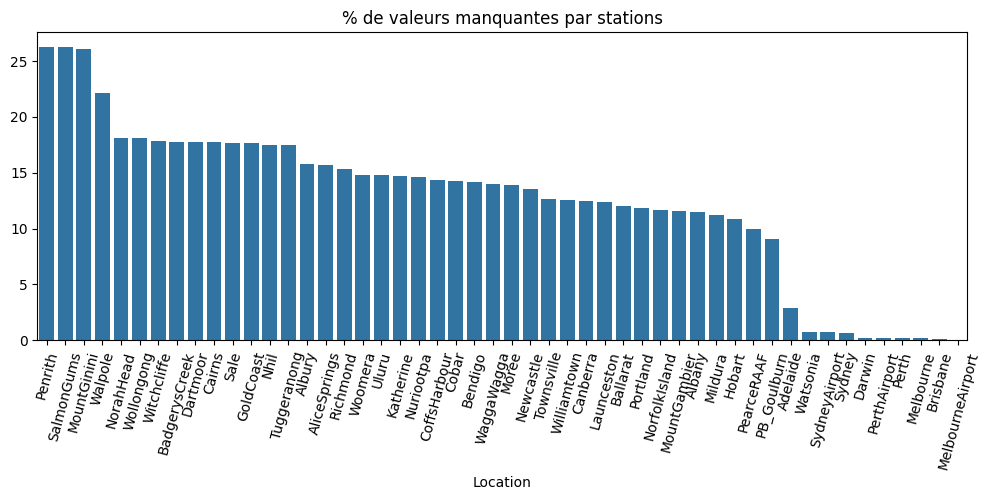

In [34]:
manque_location_apres = df.groupby("Location").apply(lambda x: x.isnull().mean() * 100).mean(axis=1).sort_values(ascending=False)

plt.figure(figsize=(12, 4))
sns.barplot(x=manque_location_apres.index, y=manque_location_apres.values)
plt.xticks(rotation=75)
plt.title('% de valeurs manquantes par stations')
plt.show()

In [35]:
# Date, Saison
df["Date"]=pd.to_datetime(df["Date"], format = "%Y-%m-%d")
df["Month"] = df['Date'].dt.month
df["Year"] = df['Date'].dt.year
df["Saison"] = df["Month"].apply( lambda x : "Eté" if x in [12, 1, 2] else "Automne" if x in [3, 4, 5] else "Hiver" if x in [6, 7, 8] else "Printemps")

In [36]:
# Analyse géographique des précipitations

# Dictionnaire climat
climat_mapping = {
    "Cairns": "Tropical",
    "Townsville": "Tropical",
    "Darwin": "Tropical",
    "Broome": "Tropical",
    "AliceSprings": "Désert",
    "CooberPedy": "Désert",
    "Oodnadatta": "Désert",
    "Kalgoorlie": "Désert",
    "Esperance": "Aride",
    "Perth": "Tempéré",
    "Albany": "Tempéré",
    "Adelaide": "Tempéré",
    "Hobart": "Tempéré",
    "Melbourne": "Tempéré",
    "Canberra": "Tempéré",
    "Sydney": "Subtropical",
    "Newcastle": "Subtropical",
    "Wollongong": "Subtropical",
    "Brisbane": "Subtropical",
    "Launceston": "Tempéré",
    "Ballarat": "Tempéré",
    "Rockhampton": "Subtropical",
    "Mildura": "Aride",
    "Cobar": "Désert",
    "MountGambier": "Tempéré",
    "NorfolkIsland": "Subtropical",
    "WaggaWagga": "Tempéré",
    "WeeWaa": "Aride",
    "Moree": "Aride",
    "Charleville": "Aride",
    "TennantCreek": "Désert",
    "Katherine": "Tropical",
    "Giles": "Désert",
    "Portland": "Tempéré",
    "Albury": "Tempéré",
    "BadgerysCreek": "Subtropical",
    "CoffsHarbour": "Subtropical",
    "NorahHead": "Subtropical",
    "Penrith": "Subtropical",
    "Richmond": "Subtropical",
    "SydneyAirport": "Subtropical",
    "Williamtown": "Subtropical",
    "Tuggeranong": "Tempéré",
    "MountGinini": "Tempéré",
    "Bendigo": "Tempéré",
    "Sale": "Tempéré",
    "MelbourneAirport": "Tempéré",
    "Nhil": "Aride",
    "Watsonia": "Tempéré",
    "Dartmoor": "Tempéré",
    "GoldCoast": "Subtropical",
    "Nuriootpa": "Tempéré",
    "Woomera": "Désert",
    "Witchcliffe": "Tempéré",
    "PearceRAAF": "Tempéré",
    "PerthAirport": "Tempéré",
    "SalmonGums": "Aride",
    "Walpole": "Tempéré",
    "Uluru": "Désert",

}

# Ajout de la colonne climate au dataframe
df['Climat'] = df["Location"].map(climat_mapping)
distrib_climat = df["Climat"].value_counts(normalize=True)*100

print(distrib_climat)


Climat
Tempéré        48.979592
Subtropical    26.530612
Désert          8.163265
Tropical        8.163265
Aride           8.163265
Name: proportion, dtype: float64


In [37]:
# 1. Suppression des stations avec >20% de manquant 
### Florent : NewCastle -> je pense que le faire après avoir ajouté des features biaise. Peut-être descendre à 20% pour capter aussi Penrith, SalmonsGums, MountGini
### ABO : Suppression manuelle de ['MountGinini', 'Penrith', 'Newcastle', 'Williamtown', 'Melbourne', 'SalmonGums'] -> delta Melbourne Williamtown
### 24-25 : 25% N'enlève rien, à 20% pour capter Penrith, SalmonsGums, MountGini
# Nombre total de cellules par Location
total_cells_per_location = df.groupby("Location").size() * (df.shape[1] - 1)  # -1 pour exclure la colonne Location elle-même
# Nombre total de NaN par Location (toutes colonnes sauf 'Location')
nan_counts_per_location = df.drop(columns="Location").isna().groupby(df["Location"]).sum().sum(axis=1)
# Ratio NaN global par Location
nan_ratio = nan_counts_per_location / total_cells_per_location
# Locations valides (moins de 20% de NaN global)
valid_locations = nan_ratio[nan_ratio <= 0.20].index
# Filtrage du DataFrame
df = df[df["Location"].isin(valid_locations)]

In [38]:
# Latitude, Longitude, Territory, District_Rainfall
with open("dico scaler/dico_station.pkl", "rb") as fichier:
    mon_dico_charge = pickle.load(fichier)
print(mon_dico_charge)  # Vérification du contenu

#Nom_rapport : (Nom_station_BOM, code station, Location, note, District Rainfall, Territory)
df_dico_station = pd.DataFrame.from_dict(mon_dico_charge, orient="index", 
                                         columns=["Nom_station_BOM", "code_station_BOM", "Location", "note", "District_Rainfall", "Territory"])

df = df.merge(df_dico_station[["District_Rainfall","Territory","Location"]], on="Location", how="left")

with open("dico scaler/dico_station_geo.pkl", "rb") as fichier:
    dico_charge = pickle.load(fichier)
print(dico_charge)  # Vérification du contenu

df_dico_station_geo = pd.DataFrame.from_dict(dico_charge, orient="index",columns=["Lat", "Lon"])
df_dico_station_geo.columns = ["Latitude", "Longitude"]
df = df.merge(right=df_dico_station_geo, left_on="Location", right_index=True, how="left")

FileNotFoundError: [Errno 2] No such file or directory: 'dico scaler/dico_station.pkl'

In [ ]:
# 2. Suppression des features pour être aligné au df_reference
df = df.drop(["Sunshine","Evaporation"], axis = 1)

In [ ]:
# 3. Traitement de la variable cible : Suppression des NaN et Label Encoder
df = df.dropna(subset=["RainTomorrow"], axis=0, how="any")

from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
df["RainTomorrow"] = encoder.fit_transform(df["RainTomorrow"])  #N=0, Y=1

### Pour analyse Analyse

In [44]:
#Supprimer les NaN? 
df.isna().sum()

Date                  0
Location              0
MinTemp             123
MaxTemp             125
Rainfall            353
Evaporation       13299
Sunshine          14277
WindGustDir         538
WindGustSpeed       451
WindDir9am          165
WindDir3pm          162
WindSpeed9am        165
WindSpeed3pm        162
Humidity9am         162
Humidity3pm         147
Pressure9am          41
Pressure3pm          39
Cloud9am           9541
Cloud3pm           9656
Temp9am              56
Temp3pm              51
RainToday             0
RainTomorrow          0
Month                 0
Year                  0
Saison                0
Climat              395
Amplitude_Temp      197
dtype: int64

In [45]:
def amplitude_thermique(X) :
    X["Amplitude_Temp"] = X['MaxTemp']- X['MinTemp']
    return X 

df = amplitude_thermique(df)

Bcp manquant cloud, manquant autour du vent (Wallpole, Wollonggong (wind provient de Bellambi qui n'a pas fonctionnée pdt aout 24 (site info sarrette au 20 Juillet. on seait donc pas pk))